In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn nltk gensim Sastrawi emoji wordcloud
!pip install transformers sentencepiece torch torchvision --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28

In [14]:
!pip install WordCloud

# **Import Dataset**

In [15]:
import re
import os
import csv
import math
import random
import string
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# NLP
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support

#word2vec
from gensim.models import Word2Vec

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# **Load Dataset**

In [4]:
# load dataset
INPUT_CSV = "tweet_gojek_grab.csv"
df = pd.read_csv(INPUT_CSV)
df = df[['keyword','tweet']].dropna().reset_index(drop=True)
print("Loaded rows:", len(df))
df.head()

Loaded rows: 1033


,keyword,tweet
0,gojek,Lah ini gojek daerah mana nih bawa glock?
1,gojek,@tubirfess kalo ngga mau satu tempat sama mere...
2,gojek,dan ongkir minimum yang diterima driver juga ...
3,gojek,@Ordinaryjhonny baru kmrn nyoba syopifud emg l...
4,gojek,"Bangsat, lu kalau mau nyaman ya bawa kendaraan..."


# **Prepocessing data**
 ## **1. membuang kata tidak baku**
 ## **2. membuang kata-kata yang sering muncul namun tidak memberikan makna yang signifikan**
 ## **3. melakukan stemming agar model lebih mudah menganalisis kata**

In [18]:
# 1. Preprocessing helpers
NORMALIZE_MAP = {
    "gk": "nggak", "ga": "nggak", "g": "nggak",
    "gk2": "nggak", "tdk": "tidak", "td": "tidak",
    "aja": "saja", "klo": "kalau", "kalo": "kalau",
    "jg": "juga", "jd": "jadi", "dgn": "dengan",
    "goblok": "goblok",
    # add more slang/abbrev here
}

# regex patterns
URL_RE = re.compile(r"https?://\S+|www\.\S+")
MENTION_RE = re.compile(r"@\w+")
HASHTAG_RE = re.compile(r"#\w+")
EMOJI_RE = re.compile("["
                      u"\U0001F600-\U0001F64F"
                      u"\U0001F300-\U0001F5FF"
                      u"\U0001F680-\U0001F6FF"
                      u"\U0001F1E0-\U0001F1FF"
                      "]+", flags=re.UNICODE)

PUNCT_TABLE = str.maketrans('', '', string.punctuation)
from nltk.corpus import stopwords
try:
    stop_words = set(stopwords.words('indonesian'))
except:
    stop_words = set(stopwords.words('english'))


# stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def normalize_text(s):
    s = str(s)
    s = s.strip()
    s = URL_RE.sub("", s)
    s = MENTION_RE.sub("", s)
    s = HASHTAG_RE.sub(lambda m: m.group(0)[1:], s)
    s = EMOJI_RE.sub("", s)
    tokens_tmp = s.split()
    tokens_tmp = [NORMALIZE_MAP.get(t.lower(), t) for t in tokens_tmp]
    s = " ".join(tokens_tmp)
    s = s.translate(PUNCT_TABLE)
    s = s.lower()
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def preprocess_text(s, do_tokenize=True, do_stopword=True, do_stem=True):
    s = normalize_text(s)
    if not do_tokenize:
        return s
    tokens = word_tokenize(s)
    if do_stopword:
        tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    if do_stem:
        tokens = [stemmer.stem(t) for t in tokens]
    return tokens

print(preprocess_text("Gojek lemot bgt si update tracking drivernya #gojek 😭 https://t.co/abc"))

# apply preprocessing to dataframe
tqdm.pandas()
df['clean_tokens'] = df['tweet'].progress_apply(lambda x: preprocess_text(x))
df['clean_text'] = df['clean_tokens'].apply(lambda toks: " ".join(toks))

['gojek', 'lot', 'bgt', 'si', 'update', 'tracking', 'drivernya', 'gojek']


  0%|          | 0/1033 [00:00<?, ?it/s]

# **Membuat wordcloud agar memudahlan analisis kata apa yang sering muncul**

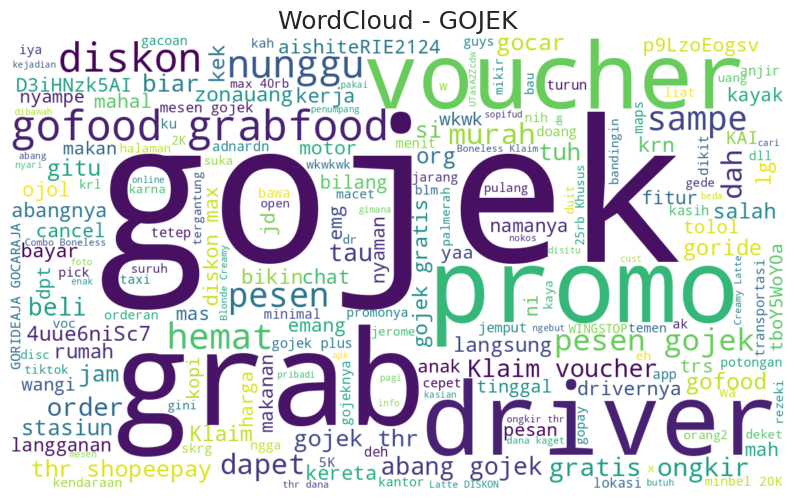

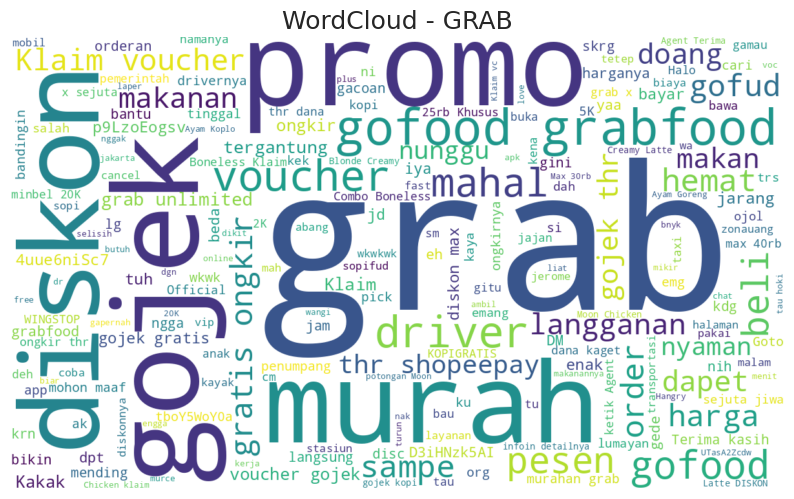

In [38]:
# Stopwords dasar
stop_words = set(stopwords.words("indonesian"))
stop_words = stop_words.union(set(stopwords.words("english")))
stop_words = stop_words.union(STOPWORDS)

# Tambahkan stopwords manual
extra_sw = {"rt", "via", "amp", "co", "https", "t", "nya", "gk", "ga", "https", "shoppe", "co", "kalo", "yang", "aja", "pake", "Ordinaryjhonny",
            "shoppefood", "kalo", "aja", "pake", "yang", "udah", "ya", "shopee", "bgt", "go", "Cetepbebek", "kadang", "sih", "banget",
            "gue", "gw", "lu", "klo", "gua", "tp", "pas", "sfood", "food", "resto", "udh", "udah", "Shopeefood", "yg", "gak", "daget",
            "cek", "jg", "abis", "habis", "kl", "kak", "titik", "kode", "jalan", "orang", "lo", "kali", "tubirfess", "akun", "utk",
            "gt", "dh", "seenaknya", "knp"}
stop_words = stop_words.union(extra_sw)

# Fungsi bikin wordcloud
def generate_wordcloud(text, title):
    wc = WordCloud(
        width=1200,
        height=700,
        background_color="white",
        stopwords=stop_words,
        collocations=True
    ).generate(text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=18)
    plt.show()

# Filter tweet berdasarkan keyword

# Tweet yang mengandung "gojek"
df_gojek = df[df["keyword"].str.lower() == "gojek"]
# Tweet yang mengandung "grab"
df_grab = df[df["keyword"].str.lower() == "grab"]

# Gabungkan jadi satu string
text_gojek = " ".join(df_gojek["tweet"].astype(str).tolist())
text_grab = " ".join(df_grab["tweet"].astype(str).tolist())

generate_wordcloud(text_gojek, "WordCloud - GOJEK")
generate_wordcloud(text_grab, "WordCloud - GRAB")


# **Labeling dataset**

In [60]:
# 2. Lexicon-based sentiment (simple)
LEXICON_CSV = "indonesian_lexicon.csv"
lexicon = {}

if os.path.exists(LEXICON_CSV):
    lex = pd.read_csv(LEXICON_CSV)
    for _, r in lex.iterrows():
        w = str(r['word']).strip().lower()
        s = float(r.get('score', 0))
        lexicon[w] = s
else:
    # fallback minimal lexicon (expand for better results)
    lexicon = {
        "bagus": 1.0, "mantap": 1.0, "mantapjiwa":1.0,
        "puas": 1.0, "murah": 1.0, "baguslah":1.0,
        "jelek": -1.0, "buruk": -1.0, "payah": -1.0,
        "kurang": -0.5, "telat": -1.0, "mal": -0.5,
        "lemot": -1.0, "nggak": -0.5, "ga": -0.5,
        "benci": -1.0, "suka": 1.0, "senang":1.0,
        "marah": -1.0, "tolol": -1.0, "nyaman":1.0,
        "murah": -1.0, "bagus": 1.0,
        "jelek": -1.0, "buruk": -1.0, "payah": -1.0,
        "kurang": -0.5, "telat": -1.0, "mal": -0.5,
        "lemot": -1.0, "nggak": -0.5, "ga": -0.5,
        "benci": -1.0, "suka": 1.0, "senang":1.0,
        "nunggu": -1.0, "tolol": -1.0, "nyaman":1.0,
        "hemat": 1.0, "promo": 1.0, "diskon": 1.0,
        "voucher": 1.0, "promosi": 1.0, "ramah": 1.0,
        "goblok": -1.0, "jahat": -1.0, "bangsat": -1.0,
        "tolol": -1.0, "sehat": 1.0, "enak": 1.0,
        "cape": -1.0, "gaada": -1.0, "gamau": -1.0,
        "fiktif": -1.0, "pukimak": -1.0, "telat": -1.0,
        "komunikatif": 1.0, "baik": 1.0,  "anjir": -1.0,
        "tidak puas": -1.0, "salah": -1.0, "nyolot": -1.0,
        "setia": 1.0, "lama": -1.0, "jarang": -1.0,
        "matiin": -1.0, "mati": -1.0, "lambat": -1.0,
        "parah": -1.0, "parah": -1.0, "mengecewakan": -1.0,
        "mahal": -1.0, "top": 1.0, "terbaik": 1.0,
        "keren": 1.0, "aman": 1.0, "cepat": 1.0,
        "thr": 1.0, "ragu": -1.0, "jarang": -1.0,
        "mual": -1.0, "pernah": 1.0, "tidak pernah": -1.0,
        "nggak pernah": -1.0, "ga pernah": -1.0, "ga ada": -1.0,
        "klaim": 1.0, "gratis": 1.0, "gratislah": 1.0,
        "potongan:": 1.0, "potong": 1.0, "potongin": 1.0,

    }

def lexicon_score(tokens):
    score = 0.0
    for t in tokens:
        score += lexicon.get(t, 0.0)
    return score

def lexicon_label(score, pos_thr=0.5, neg_thr=-0.5):
    if score >= pos_thr:
        return "positive"
    elif score <= neg_thr:
        return "negative"
    else:
        return "neutral"

df['lex_score'] = df['clean_tokens'].apply(lambda toks: lexicon_score(toks))
df['lex_label'] = df['lex_score'].apply(lexicon_label)
print("Lexicon distribution:\n", df['lex_label'].value_counts())

Lexicon distribution:
 lex_label
neutral     436
negative    312
positive    285
Name: count, dtype: int64


# **Ekstraksi fitur dengan TF-IDF**

In [61]:
# 3. Feature extraction
# BoW and TF-IDF
tfidf = TfidfVectorizer(max_features=8000, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(df['clean_text'])

# optionally Word2Vec (train on our token lists)
w2v_model = Word2Vec(sentences=df['clean_tokens'].tolist(), vector_size=100, window=5, min_count=2, workers=2, epochs=10)
def doc_vector(tokens):
    vecs = []
    for t in tokens:
        if t in w2v_model.wv:
            vecs.append(w2v_model.wv[t])
    if not vecs:
        return np.zeros(w2v_model.vector_size)
    return np.mean(vecs, axis=0)
X_w2v = np.vstack([doc_vector(toks) for toks in df['clean_tokens']])

In [63]:
# 4. Supervised ML
df_ml = df.copy()
df_ml = df_ml[df_ml['lex_label'].isin(['positive','negative','neutral'])].reset_index(drop=True)
y = df_ml['lex_label'].map({'negative':0,'neutral':1,'positive':2}).values
X = tfidf.transform(df_ml['clean_text'])  # use TF-IDF features; or use X_w2v

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# models to try
models = {
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(max_iter=200),
    "LinearSVC": LinearSVC(max_iter=2000)
}

results = {}
for name, model in models.items():
    print("Training", name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['neg','neu','pos'])
    print(name, "accuracy:", acc)
    print(report)
    results[name] = {
        "model": model,
        "accuracy": acc,
        "report": report,
        "y_pred": y_pred
    }
best_name = max(results.keys(), key=lambda k: results[k]['accuracy'])
best_model = results[best_name]['model']
print("Best model:", best_name, results[best_name]['accuracy'])

Training MultinomialNB
MultinomialNB accuracy: 0.7439613526570048
              precision    recall  f1-score   support

         neg       0.76      0.67      0.71        63
         neu       0.65      0.85      0.74        87
         pos       0.97      0.67      0.79        57

    accuracy                           0.74       207
   macro avg       0.80      0.73      0.75       207
weighted avg       0.78      0.74      0.75       207

Training LogisticRegression
LogisticRegression accuracy: 0.7729468599033816
              precision    recall  f1-score   support

         neg       0.86      0.67      0.75        63
         neu       0.67      0.93      0.78        87
         pos       1.00      0.65      0.79        57

    accuracy                           0.77       207
   macro avg       0.84      0.75      0.77       207
weighted avg       0.82      0.77      0.77       207

Training LinearSVC
LinearSVC accuracy: 0.8115942028985508
              precision    recall  f1-

# **training**

In [65]:
# menggunakan model terbaik untuk prediksi ke seluruh dataset
X_all = tfidf.transform(df['clean_text'])
y_all_pred = best_model.predict(X_all)
inv_map = {0:'negative',1:'neutral',2:'positive'}
df['ml_label'] = [inv_map[int(i)] for i in y_all_pred]

# Compare lexicon vs ml counts
print("Lexicon counts:\n", df.groupby('keyword')['lex_label'].value_counts().unstack(fill_value=0))
print("\nML counts:\n", df.groupby('keyword')['ml_label'].value_counts().unstack(fill_value=0))

# Save CSV with labels
OUT_CSV = "tweet_gojek_grab_labeled.csv"
df.to_csv(OUT_CSV, index=False)
print("Saved labeled CSV:", OUT_CSV)

Lexicon counts:
 lex_label  negative  neutral  positive
keyword                               
gojek           146      232       137
grab            166      204       148

ML counts:
 ml_label  negative  neutral  positive
keyword                              
gojek          140      246       129
grab           166      207       145
Saved labeled CSV: tweet_gojek_grab_labeled.csv


In [66]:
# 6. Evaluation helper
def evaluate_with_gold(y_true, y_pred, labels=['negative','neutral','positive']):
    print(classification_report(y_true, y_pred, labels=labels))
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
    plt.xlabel("pred")
    plt.ylabel("true")
    plt.show()

# **Visualisasi**

COUNT PER SENTIMENT


ml_label,negative,neutral,positive
keyword,,,
gojek,140,246,129
grab,166,207,145



 PERCENTAGE PER SENTIMENT (%) 


ml_label,negative,neutral,positive
keyword,,,
gojek,27.18,47.77,25.05
grab,32.05,39.96,27.99


<Figure size 1000x400 with 0 Axes>

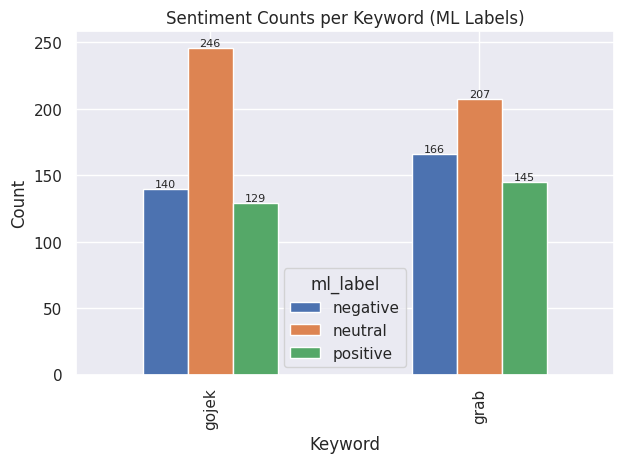

<Figure size 1000x400 with 0 Axes>

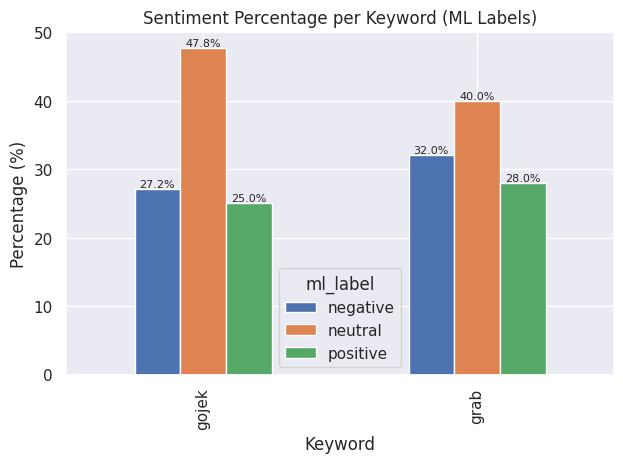

In [71]:
#Hitung jumlah
count_df = df.groupby(['keyword','ml_label']).size().unstack(fill_value=0)

#Hitung persentase
percent_df = count_df.div(count_df.sum(axis=1), axis=0) * 100

print("COUNT PER SENTIMENT")
display(count_df)

print("\n PERCENTAGE PER SENTIMENT (%) ")
display(percent_df.round(2))

# --- Plot ---
plt.figure(figsize=(10,4))
ax = count_df.plot(kind='bar', stacked=False)

plt.title("Sentiment Counts per Keyword (ML Labels)")
plt.xlabel("Keyword")
plt.ylabel("Count")

# tampilkan nilai di atas bar
for p in ax.patches:
    ax.annotate(
        str(p.get_height()),
        (p.get_x() + p.get_width()/2, p.get_height()),
        ha='center', va='bottom', fontsize=8
    )

plt.tight_layout()
plt.show()

# --- Plot Persentase (opsional) ---
plt.figure(figsize=(10,4))
ax2 = percent_df.plot(kind='bar', stacked=False)

plt.title("Sentiment Percentage per Keyword (ML Labels)")
plt.xlabel("Keyword")
plt.ylabel("Percentage (%)")

# tampilkan angka persentasenya
for p in ax2.patches:
    ax2.annotate(
        f"{p.get_height():.1f}%",
        (p.get_x() + p.get_width()/2, p.get_height()),
        ha='center', va='bottom', fontsize=8
    )

plt.tight_layout()
plt.show()
